# Final Project Advanced Statistics
## Study of Earthquakes in Italy
### Luca Agosti(2062889)     Nicola Bee (2057136)


This seismic study is organized in 4 different parts:

0) Introduction and choice of the dataset

1) Study on the Gutenberg–Richter law

2) Time series Analysis

3) Hierarchical Cluster Analysis 

### Libraries used during the project

In [1]:
#install.packages("reshape2")

In [26]:
library(tidyverse)
library(png)
library(grid)
library(gridExtra)
library(plot.matrix)

library(fable)
library(tsibble)
library(stringr)
library(feasts)
library(lubridate)

library(rnaturalearth)
library(rnaturalearthdata)
library(reshape2)

## 0) Introduction to the project and choice of the dataset

Our aim is to study all the earthquakes with magnitude 5.0+ registred in Italy and the areas surranding it in the period between 1920 and 2020. We gathered this dataset from the suggested  USGS Earthquake Hazards Web Site [1]. The area of our study is reported in the image below and can be summarized as the smallest rectangle containing all the territory of Italy (not considering all the Mediterranian islands like Lampedusa)

In the cells below is reported a quick overview of our earthquakes database.

### 0.1 Geographical area object of our study

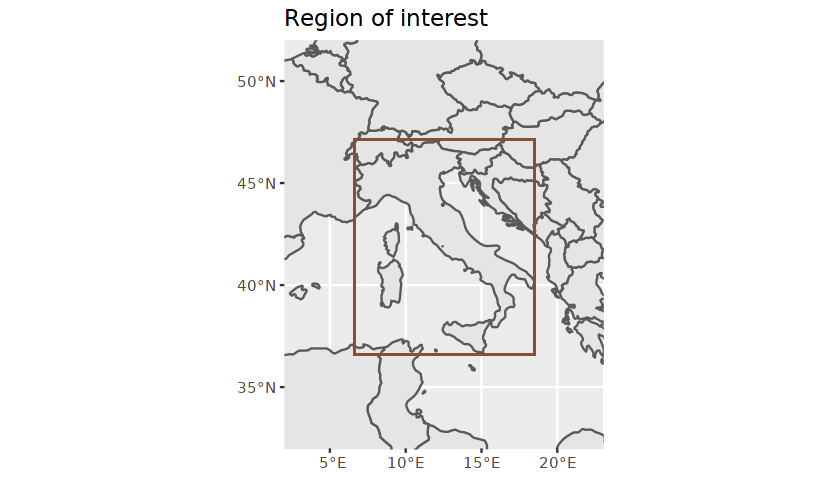

In [3]:
options(repr.plot.height=4)
world <- ne_countries(scale = "medium", returnclass = "sf")
#str(world)
ggplot(data = world) +
    geom_sf() +
    coord_sf(xlim = c(2, 23), ylim = c(32, 52), expand = FALSE)+
    geom_rect(aes(xmin=6.6, xmax=18.5, ymin=36.6, ymax=47.14), colour='salmon4', fill=NA)+
    ggtitle('Region of interest')

### 0.2 Earthquakes database

In [4]:
df <- as_tibble(read.csv('query.csv'),header=T)
head(df, 10)

time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,...,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>
2020-12-29T11:19:54.762Z,45.4244,16.2573,10.00,6.4,mww,NA,13,0.941,0.75,...,2022-07-23T13:38:28.016Z,"2 km WSW of Petrinja, Croatia",earthquake,4.4,1.8,0.033,89,reviewed,us,us
2020-11-22T03:53:08.474Z,36.6442,6.8625,10.00,5.1,mww,NA,37,2.205,1.25,...,2022-03-10T05:48:26.167Z,"24 km WSW of Azzaba, Algeria",earthquake,6.5,1.8,0.048,41,reviewed,us,us
2020-03-22T05:24:03.700Z,45.9072,15.9697,10.00,5.3,mww,NA,12,0.794,0.59,...,2022-03-10T05:09:50.989Z,"5 km E of Gornja Bistra, Croatia",earthquake,3.7,1.8,0.035,79,reviewed,us,us
2019-11-26T09:19:25.856Z,43.2235,17.9118,10.00,5.3,mww,NA,24,1.270,0.86,...,2020-12-29T14:18:53.242Z,"4 km SSE of Blagaj, Bosnia and Herzegovina",earthquake,5.5,1.8,0.058,29,reviewed,us,us
2018-12-26T02:19:14.000Z,37.6300,15.1000,1.00,5.0,mwr,NA,NA,NA,1.07,...,2022-05-03T19:42:42.222Z,"1 km SSW of Lavinaio-Monterosso, Italy",earthquake,5.1,3.2,0.080,15,reviewed,rom,us
2018-08-16T18:19:05.400Z,41.8753,14.8084,11.59,5.3,mww,NA,25,0.687,1.14,...,2022-05-03T19:27:17.024Z,"2 km SE of Palata, Italy",earthquake,4.9,3.7,0.048,41,reviewed,us,us
2017-01-18T13:33:38.000Z,42.5581,13.2487,7.39,5.2,mww,NA,33,0.120,0.60,...,2022-05-03T18:14:23.688Z,"3 km N of Montereale, Italy",earthquake,5.2,3.8,NA,NA,reviewed,us,us
2017-01-18T10:25:25.490Z,42.5855,13.1904,10.00,5.6,mww,NA,30,0.169,0.55,...,2022-05-03T18:09:16.530Z,"4 km SE of Cittareale, Italy",earthquake,5.2,1.8,NA,NA,reviewed,us,us
2017-01-18T10:14:10.980Z,42.6012,13.2268,7.00,5.7,mww,NA,27,0.149,0.55,...,2022-05-03T18:57:21.108Z,"5 km ESE of Cittareale, Italy",earthquake,5.2,1.8,NA,NA,reviewed,us,us


### 0.3 Histogram of magnitude

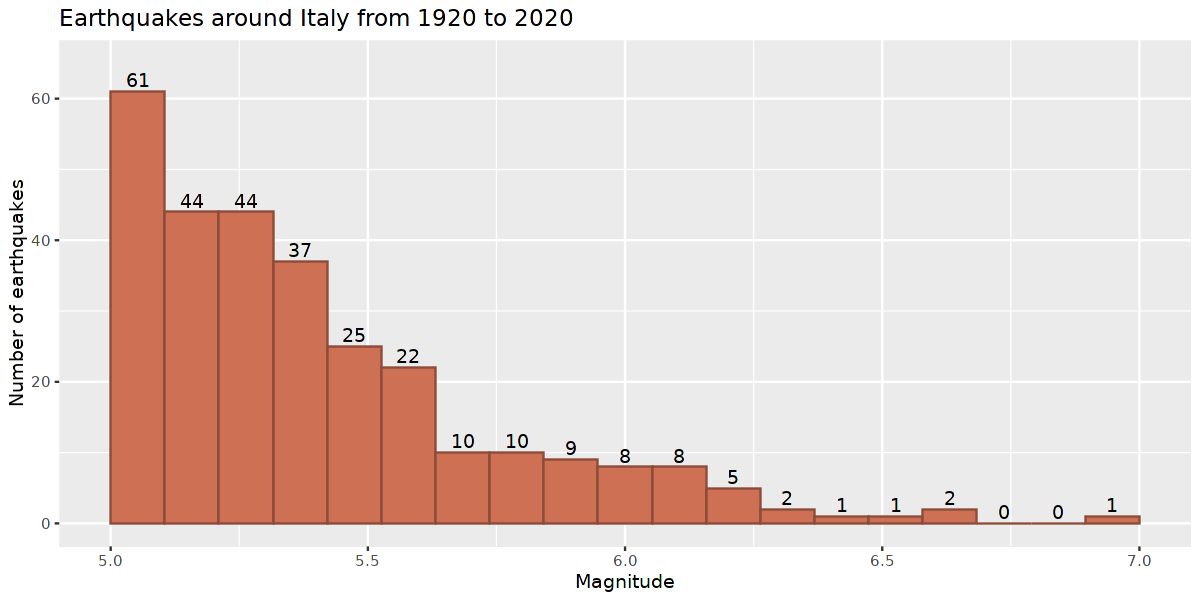

In [5]:
options(repr.plot.width=10, repr.plot.height=5)
ggplot(df, aes(x=mag))+ 
    stat_bin(breaks=seq(5, 7, length.out=20), fill='salmon3', color='salmon4') + 
    stat_bin(breaks=seq(5, 7, length.out=20), geom="text", aes(label=..count..), vjust=-0.3) + #numbers
    coord_cartesian(xlim = c(5, 7), ylim = c(0,65)) + 
    ylab('Number of earthquakes') + 
    xlab('Magnitude') +
    ggtitle('Earthquakes around Italy from 1920 to 2020')

### 0.4 Geographical position of the earthquakes

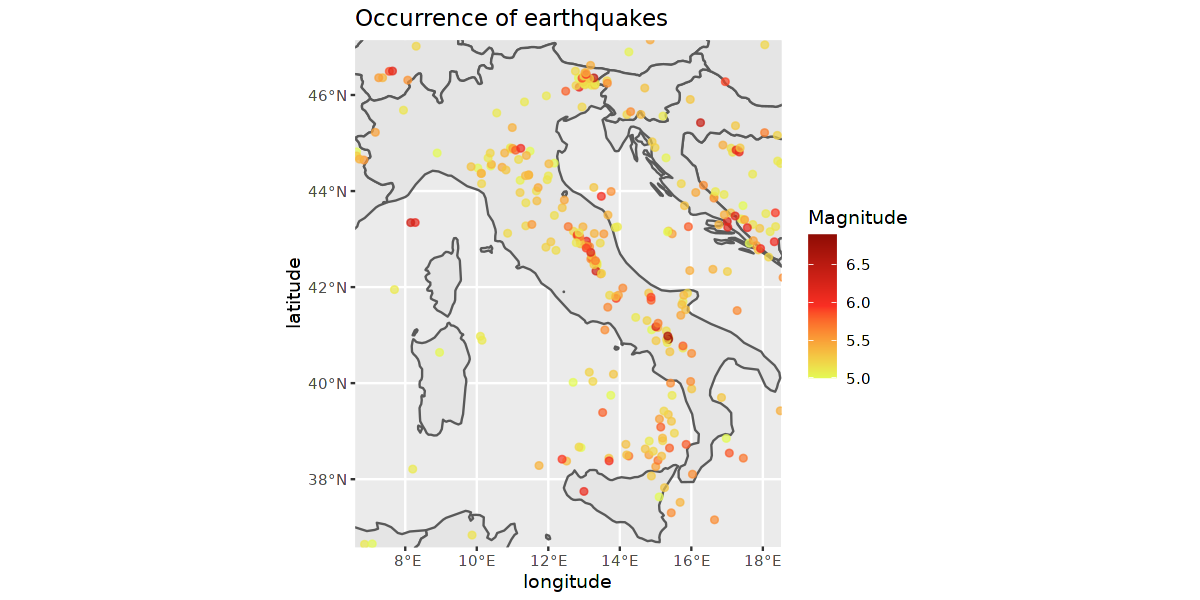

In [6]:
ggplot(data = world) +
    geom_sf() +
    coord_sf(xlim = c(6.6, 18.5), ylim = c(36.6, 47.14), expand = FALSE)+
    geom_point(data=df, aes(x=longitude, y=latitude, colour=mag), alpha=0.7)+
    scale_colour_gradientn(colors=c("#e4fa55","#fa2f23","#8f0c04"), name='Magnitude')+
    ggtitle('Occurrence of earthquakes')

### 0.5 Histogram of number of earthquakes for each year

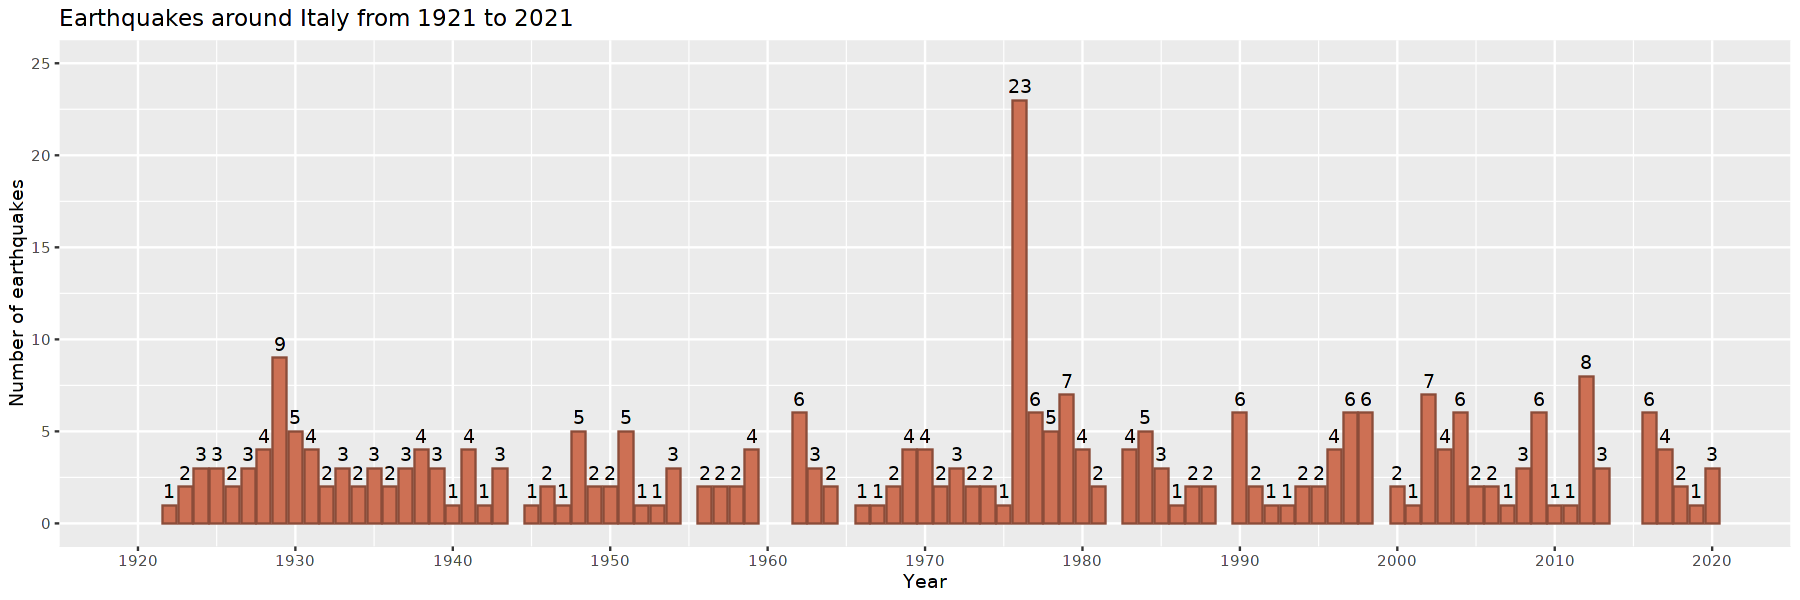

In [7]:
options(repr.plot.width=15, repr.plot.height=5)

Nerqk <- df %>% count(year=year(time))

#str(Nerqk)
ggplot(Nerqk, aes(x=year, y=n))+ 
    geom_col(fill='salmon3', color='salmon4')+ 
    geom_text(aes(label = n), vjust = -0.5)+
    coord_cartesian(xlim = c(1920,2020), ylim=c(0,25))+
    ylab('Number of earthquakes') + 
    xlab('Year') +
    scale_x_continuous(breaks = seq(1920, 2020, by = 10))+
    ggtitle('Earthquakes around Italy from 1921 to 2021')

## 1) Study on the Gutenberg–Richter law

### 1.1 Linear Fit of the law

The first analysis that we did on the dataset was a study on the Gutenberg-Richter law of earthquakes which states that in seismology the relationship between the magnitude and total number of earthquakes in any given region and time period of at least that magnitude is given by:

$N=10^{a+bM}$

where:
-) N is the number of events having a magnitude greater or equal to M.
-) a and b are constants.

We first studied if this relationship holds for our dataset by doing a linear fit in the logaritmic space. We are interested in estimating the parameter "b" of the model, which represet the proportion of small and big earthquakes in the region.


Call:
lm(formula = logN ~ M, data = dataF)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.28789 -0.06530  0.01578  0.06686  0.18835 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.65036    0.20029   48.18   <2e-16 ***
M           -1.38703    0.03351  -41.39   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1178 on 37 degrees of freedom
Multiple R-squared:  0.9789,	Adjusted R-squared:  0.9783 
F-statistic:  1713 on 1 and 37 DF,  p-value: < 2.2e-16



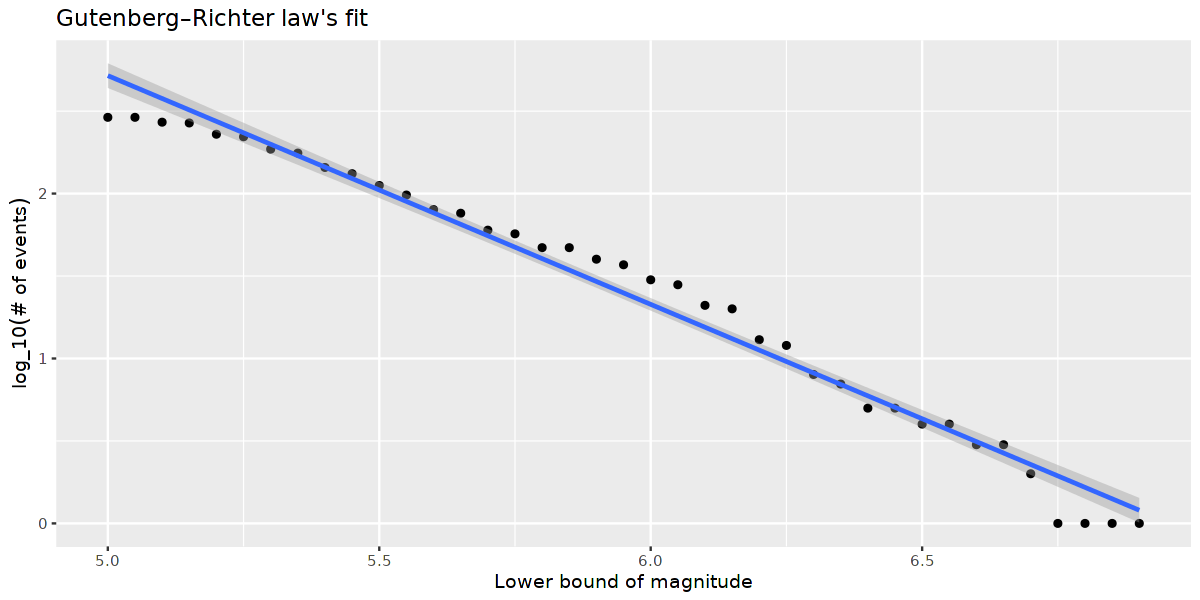

In [8]:
M <- seq(5,6.9,0.05)

N <- c()

totEarthquakes <- nrow(df)

for (i in 0:38) {
    N <- append(N, sum(df$mag > 4.9 + i*0.05))
}

# Linear fit in the log space

logN <- log10(N)

dataF <- data.frame(M, logN)

GR <- lm(logN ~ M, data = dataF)

print(summary(GR))

options(repr.plot.width=10, repr.plot.height=5)

#plot(dataF)
#abline(GR)

ggplot(dataF, aes(x=M, y=logN))+
    geom_point()+
    geom_smooth(method='lm', formula= y~x)+
    ylab(expression(log_10('# of events'))) + 
    xlab('Lower bound of magnitude') +
    ggtitle('Gutenberg–Richter law\'s fit')

### 1.2 Predictor for earthquakes frequency based on their magnitude

Once that the parameter "b" is known it is possible to build a predictor for earthquakes frequencies based on the magnitude given in input, for example if M = 6.3, the same of the L'Aquila earthquake, from the G-R law we obtain that in our region we expect 8.166 earthquakes of magnitude greater or equal to 6.3 every 100 years.

In [9]:
Mag <- 6.3

a <- summary(GR)$coefficients[1]
b <- summary(GR)$coefficients[2]
std_a <-summary(GR)$coefficients[3]  
std_b <- summary(GR)$coefficients[4]

GRlaw <- 10^(summary(GR)$coefficients[1] + summary(GR)$coefficients[2]*Mag)
GRlaw <- formatC(GRlaw, digits = 1, format = "f")
GRstd <- sqrt((std_a)^2+(Mag*std_b)^2)
GRstd <- formatC(GRstd, digits = 1, format = "f")
cat("From the Gutenberg–Richter law we can expect, on average:", GRlaw, "\U00b1", GRstd,"\nearthquakes with a magnitude over:", Mag, "\nin Italy every 100 years")

From the Gutenberg–Richter law we can expect, on average: 8.2 ± 0.3 
earthquakes with a magnitude over: 6.3 
in Italy every 100 years

### 1.3 Building a sesmic risk map based on the G-R law

The problem with our analysis in section 1.2 is that we are considering the territory of our study as one homogeneuous region and describing the seismic risk as a property of the whole area. In practice this is not true at all, just a difference of a few tenths of kilometers could mean moving from a high to a low seismic risk region. We could account for this property by dividing our area in a 10x10 grid and doing a linear fit for the G-R law in each cell. In this way we will have 100 different estimation of the seismic risk, one for each cell, and this could improve by a lot our precision in determining the seismic risk.

Our results are represented in the graph below. White cells mean that there are not enough data in that region to fit the G-R law and therefore that we cannot estimate the seismic risk of the cell.

In [10]:
maxLong<-max(df$longitude)
minLong<-min(df$longitude)
maxLat<-max(df$latitude)
minLat<-min(df$latitude)

gridLong<-seq(minLong, maxLong, length.out=11)
gridLat<-seq(minLat, maxLat, length.out=11)

#Loop for the creation of all the subdataframes, one for each cell, so 100 in total.

#From the subdataframes we can fit the G-R law and calculate an estimation of the
#seismic risk for each cell

bParam <- c()
for (i in 1:10){
    for (j in 1:10){
        subdf <- subset(df, longitude>=gridLong[i] & longitude<=gridLong[i+1] & latitude>=gridLat[11-j] & latitude<=gridLat[12-j])
        totEarthquakes <- nrow(subdf)
        M <- seq(5,6.9,0.05)
        v <- c()
        if (totEarthquakes > 2){
            for (param in 0:38) {
                v <- append(v, sum(subdf$mag > 4.9 + param*0.05))
            }
            logv <- log10(v[!is.infinite(log10(v))])
            bins <- 0
            Mlog <- c()
            while (length(Mlog) != length(logv)){
                Mlog <- append(Mlog, 5+0.05*bins)
                bins = bins+1
            }
            dataF <- data.frame(Mlog, logv)
            GR <- lm(logv ~ Mlog, data = dataF)
            summary(GR)
            bParam <- append(bParam, -summary(GR)$coefficients[2])
        }
        else {
            bParam <- append(bParam, NaN)
        }
    }
}

bParam <- matrix(bParam, 10, 10)

#Number of earthquakes with magnitude of 6.3+ expected every 100 years from the G-R law
#White squares means: not enough data to fit the model (low sismic risk)

Mag <- 6.3
GRlaw <- 10^(summary(GR)$coefficients[1] - bParam*Mag)

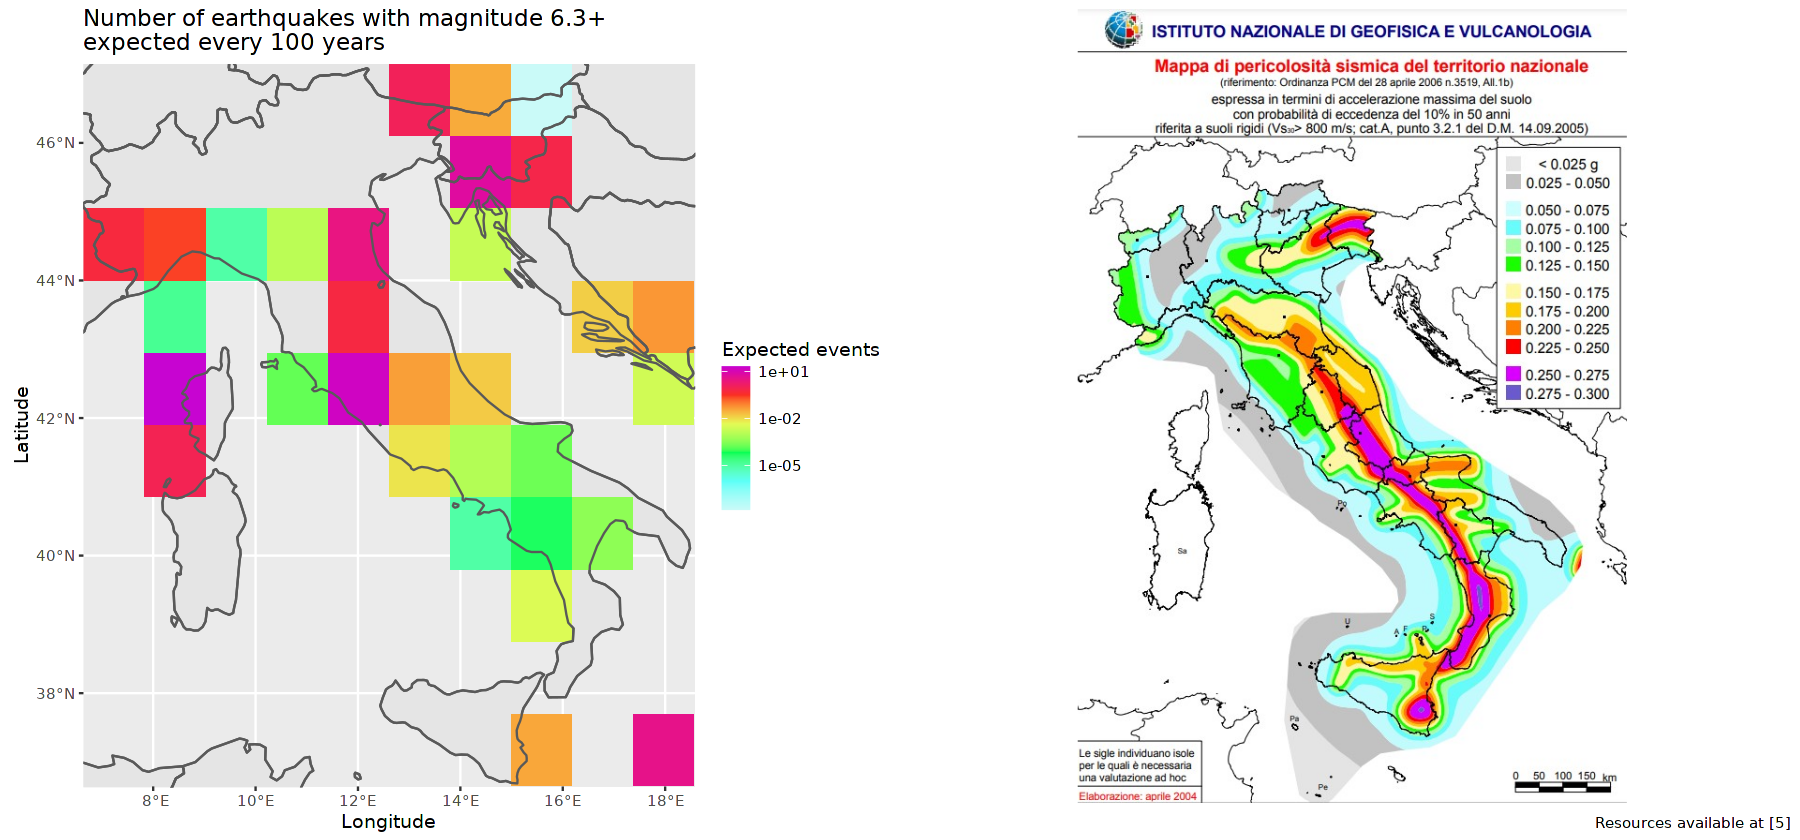

In [11]:
gridLong <- rev(gridLong[-11])
gridLat  <- gridLat[-11]

data_matrix <- matrix(GRlaw, nrow=10, dimnames=list(gridLong,gridLat))
data_matrix <- melt(data_matrix, c("Longitude","Latitude"), value.name = "Val")

p1 <- ggplot(data = world) +
        geom_sf()+
        geom_raster(data=data_matrix,aes(x=Longitude,y=Latitude,fill=Val), na.rm = TRUE, hjust=1, vjust=1)+
        scale_fill_gradientn(colors=c('#cafaf8',"#5cfff7","#00ff55","#e4fa55","#fa2f23",'#c704d1'), 
                             na.value = NA, name='Expected events', trans="log10")+
        geom_sf(fill=NA)+ #add borders over tiles
        coord_sf(xlim = c(minLong, maxLong), ylim = c(minLat, maxLat), expand = FALSE)+
        ggtitle('Number of earthquakes with magnitude 6.3+ \nexpected every 100 years')
        #theme(plot.title = element_text(size = 12))

img <- readPNG("Mappa_rischio_sismico.png")
g <- rasterGrob(img, interpolate=TRUE)
p2 <- qplot(1:10, 1:10, geom="blank") +
        annotation_custom(g, xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf) +
        geom_point(na.rm = TRUE, color=NA)+
        theme(panel.background = element_rect(color=NA, fill=NA), 
            axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.title.x=element_blank(),
            axis.text.y=element_blank(), axis.ticks.y=element_blank(), axis.title.y=element_blank() )+
        labs(caption='Resources available at [5]')

options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(p1, p2, ncol=2)

#### 1.3.1 Building a new seismic risk map with an enlarged dataset

In [12]:
df_2 <- as_tibble(read.csv('query_2.csv'),header=T)
min(df_2$mag)
max(df_2$mag)

[1] 2.5

[1] 6.9

In [13]:
maxLong<-max(df_2$longitude)
minLong<-min(df_2$longitude)
maxLat<-max(df_2$latitude)
minLat<-min(df_2$latitude)

gridLong<-seq(minLong, maxLong, length.out=11)
gridLat<-seq(minLat, maxLat, length.out=11)

bParam <- c()
for (i in 1:10){
    for (j in 1:10){
        subdf <- df_2 %>% subset(longitude>=gridLong[i] & longitude<=gridLong[i+1] & latitude>=gridLat[11-j] & latitude<=gridLat[12-j])
        totEarthquakes <- nrow(subdf)
        M <- seq(2.5,6.9,0.05)
        v <- c()
        if (totEarthquakes > 50){ #Fitting only with at least 50 events per cell
            for (param in 0:88) {
                v <- append(v, sum(subdf$mag > 2.5 + param*0.05))
            }
            logv <- log10(v[!is.infinite(log10(v))])
            bins <- 0
            Mlog <- c()
            while (length(Mlog) != length(logv)){ 
                Mlog <- append(Mlog, 5+0.05*bins)
                bins = bins+1            
            }
            dataF <- data.frame(Mlog, logv)
            GR <- lm(logv ~ Mlog, data = dataF)
            summary(GR)
            bParam <- append(bParam, -summary(GR)$coefficients[2])
        }
        else {
            bParam <- append(bParam, NaN)
        }
    }
}

bParam <- matrix(bParam, 10, 10)

#Number of earthquakes with magnitude of 6.3+ expected every 100 years from the G-R law
#White squares means: not enough data to fit the model (low seismic risk)

Mag <- 6.3
GRlaw <- 10^(summary(GR)$coefficients[1] - bParam*Mag)

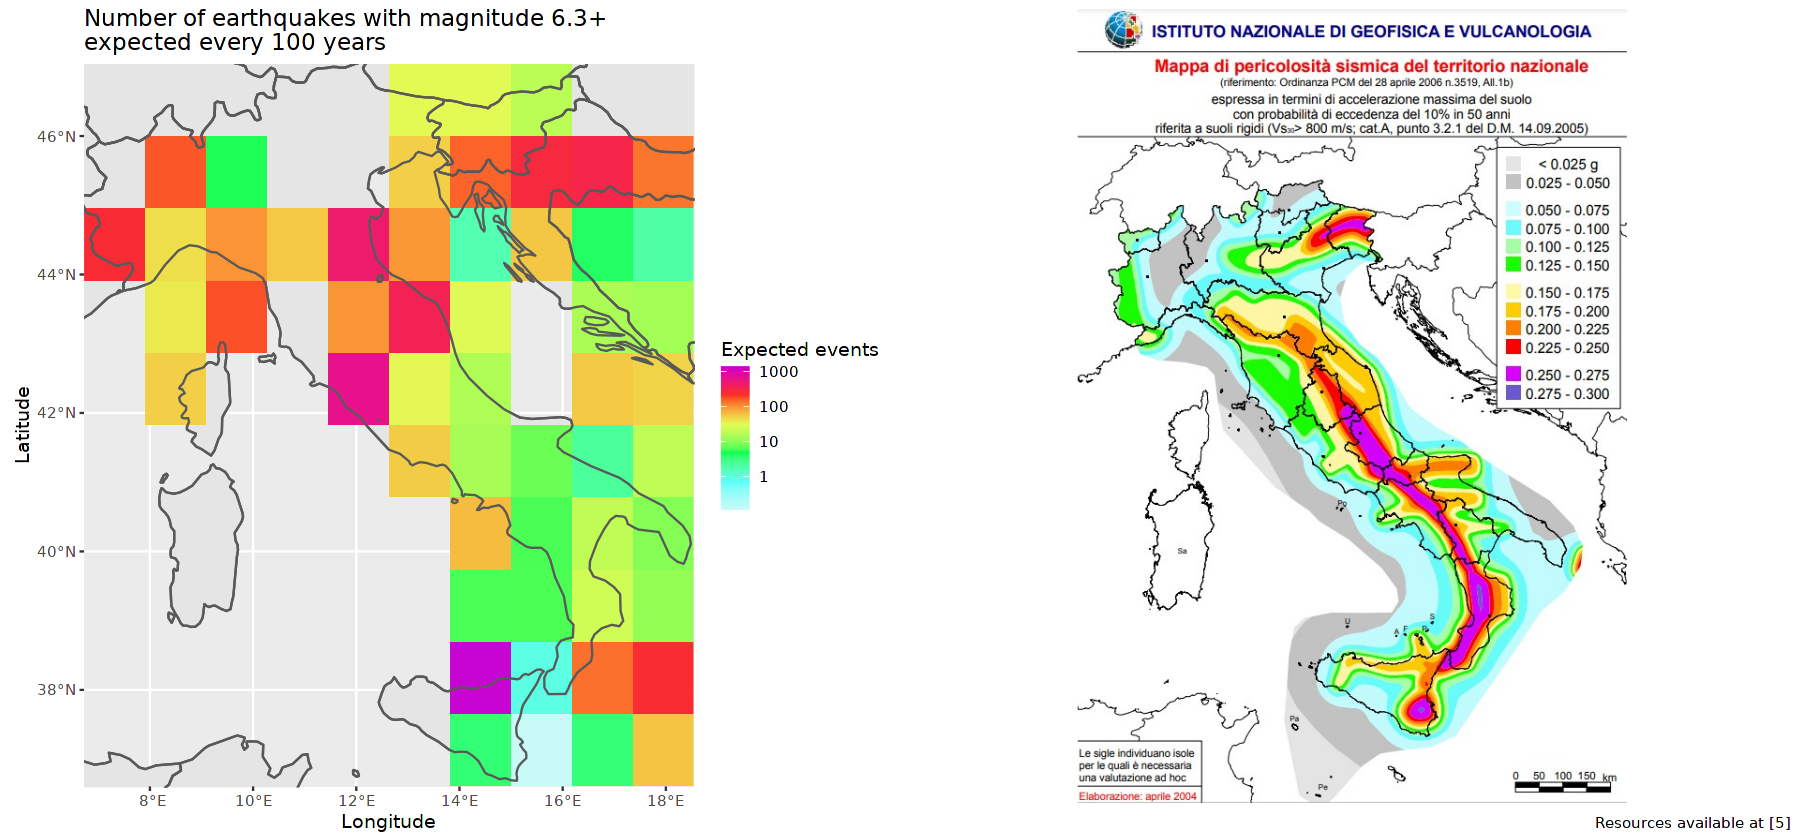

In [14]:
gridLong <- rev(gridLong[-11])
gridLat  <- gridLat[-11]

data_matrix <- matrix(GRlaw, nrow=10, dimnames=list(gridLong,gridLat))
data_matrix <- melt(data_matrix, c("Longitude","Latitude"), value.name = "Val")

p1 <- ggplot(data = world) +
        geom_sf()+
        geom_raster(data=data_matrix,aes(x=Longitude,y=Latitude,fill=Val), na.rm = TRUE, hjust=1, vjust=1)+
        scale_fill_gradientn(colors=c('#cafaf8',"#5cfff7","#00ff55","#e4fa55","#fa2f23",'#c704d1'), 
                             na.value = NA, name='Expected events',trans="log10")+
        geom_sf(fill=NA)+ #add borders over tiles
        coord_sf(xlim = c(minLong, maxLong), ylim = c(minLat, maxLat), expand = FALSE)+
        ggtitle('Number of earthquakes with magnitude 6.3+ \nexpected every 100 years')
        #theme(plot.title = element_text(size = 12))

img <- readPNG("Mappa_rischio_sismico.png")
g <- rasterGrob(img, interpolate=TRUE)
p2 <- qplot(1:10, 1:10, geom="blank") +
        annotation_custom(g, xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf) +
        geom_point(na.rm = TRUE, color=NA)+
        theme(panel.background = element_rect(color=NA, fill=NA), 
            axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.title.x=element_blank(),
            axis.text.y=element_blank(), axis.ticks.y=element_blank(), axis.title.y=element_blank() )+
        labs(caption='Resources available at [5]')

options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(p1, p2, ncol=2)

## 2) Time series Analysis

### 2.1 Creation of the AEM and MEM time series

The second type of study that we did on our dataset is a time series analysis. A time series is a series of data points indexed in time order. Most commonly, a time series is a sequence taken at successive equally spaced points in time. It is immediatly obvious that the earthquake events by themselfs does not fit very well with the definition of a time series, since they are extremely irregular events in time. For applying this type of analysis to our databse we were inspired by the work done is this article [2] and we decided to follow a similar study. We defined two different time series: AEM (Average Earthquakes Magnitude) and MEM (Maximum Earthquakes Magnitude) using as time step one year. In this way we obtained two time series that we can use to forecast the trend of earthquakes in the future. 

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


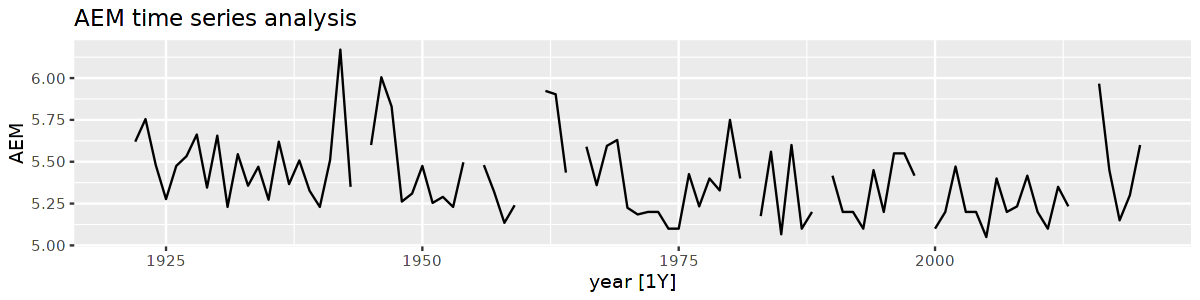

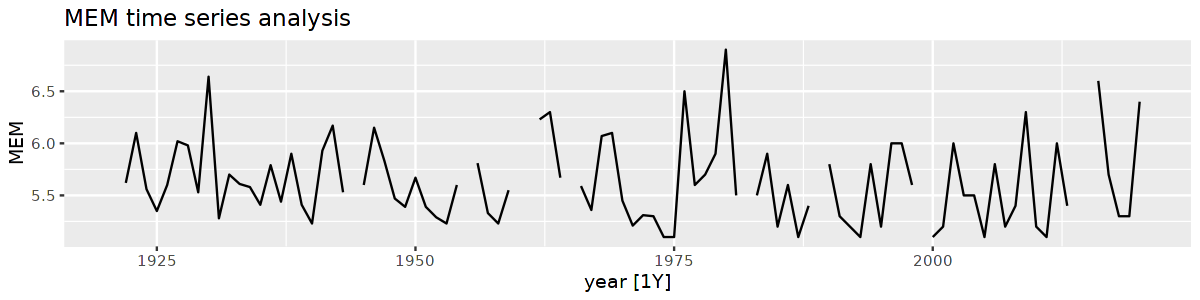

In [15]:
# "Cleaning" our time and date column
  
df_t<-df
df_t$time<-str_replace_all(df_t$time, c('T' = ' ', 'Z' = ''))
df_t$time<-gsub("\\..*","",df_t$time)
df_t$time <- as.POSIXct(df_t$time) 

# Time series Analysis for our project - Creating the AEM and MEM time series

df_ts<-df
df_ts$time<-as.Date(df_ts$time)
df_ts$time<-format(df_ts$time, "%Y")

AEM<-c()
MEM<-c()
year<-c(1921:2020)
index<-1

for (i in year){
    subdf_ts<-subset(df_ts, time==i)
    if (nrow(subdf_ts)!=0){
        AEM[index]<-mean(subdf_ts$mag)
        MEM[index]<-max(subdf_ts$mag)
    }
    else {
        AEM[index]<-"NaN"
        MEM[index]<-"NaN"
    }
    index<-index+1
}

AEM<-as.double(AEM)
MEM<-as.double(MEM)

AEM_ts<-data.frame(year, AEM)
MEM_ts<-data.frame(year, MEM)

# Plotting the AEM and MEM time series

#options(repr.plot.width=10, repr.plot.height=5)
options(repr.plot.width=10, repr.plot.height=2.5)

AEM_tsb <- as_tsibble(AEM_ts, index = year)
AEM_tsb<-fill_gaps(AEM_tsb, .full = FALSE)
AEM_tsb %>%
    autoplot(AEM) +
    ggtitle('AEM time series analysis')

MEM_tsb <- as_tsibble(MEM_ts, index = year)
MEM_tsb<-fill_gaps(MEM_tsb, .full = FALSE)
MEM_tsb %>%
    autoplot(MEM)+
    ggtitle('MEM time series analysis')

### 2.2 Fitting our time series with the ARIMA model

Now that we have defined two time series to work on we can fit them using the ARIMA model (AutoRegressive Integrated Moving Average).

In [16]:
# Fitting the ARIMA model while imposing that it should be autoregressive and moving average
# meaning that p,q != 0

fit_AEM<- AEM_tsb %>%
  model(
    arima = ARIMA(AEM ~ pdq(p = 1:5, d = 0:2, q = 1:5))
  )
fit_AEM

fit_MEM <- MEM_tsb %>%
  model(
    arima = ARIMA(MEM ~ pdq(p = 1:5, d = 0:2, q = 1:5))
  )
fit_MEM

Warning message:
“1 error encountered for arima
[1] The `urca` package must be installed to use this functionality. It can be installed with install.packages("urca")
”


arima
<model>
<NULL model>


Warning message:
“1 error encountered for arima
[1] The `urca` package must be installed to use this functionality. It can be installed with install.packages("urca")
”


arima
<model>
<NULL model>


### 2.3 Forecasting AEM and MEM using the ARIMA model

Once the model is fitted we can make use of the forecast() function of the "fable" package to make prediction on the trend of the AEM and MEM time series. We reported a table showing the evolution of these time series for the next 10 years starting from 2020 with their correspondent 95% and 80% confidence intervals. We also plotted the results of our prediction at the end of this section.

In [17]:
# Forecasting using as time unit 1 year

fc_AEM <- fit_AEM %>%
  forecast(h = 10)

fc_AEM_copy<-fc_AEM
colnames(fc_AEM_copy)<-c(".model", "Year", "as.double.AEM", "Forecasted_AEM")
AEM_results<-fc_AEM_copy[,c(2,4)]

fc_MEM <- fit_MEM %>%
  forecast(h = 10)

fc_MEM_copy<-fc_MEM
colnames(fc_MEM_copy)<-c(".model", "Year", "as.double.MEM", "Forecasted_MEM")
MEM_results<-fc_MEM_copy[,c(4)]

df_forecast<-data.frame(AEM_results, MEM_results)

append1 <- fc_AEM %>% hilo(level = c(80, 95)) %>% select(c(5,6))
append2 <- fc_MEM %>% hilo(level = c(80, 95)) %>% select(c(5,6))

tmp <- df_forecast %>% add_column('80% c.i.'= append1$'80%', '95% c.i.'= append1$'95%','80% c.i'=append2$'80%', '95% c.i'=append2$'95%') %>%
                relocate(c('80% c.i.', '95% c.i.'), .after=Forecasted_AEM	) %>% relocate(c('80% c.i', '95% c.i'), .after=Forecasted_MEM)

df_forecast %>% add_column('95% c.i.'= append1$'95%', '95% c.i'=append2$'95%') %>%
                relocate('95% c.i.', .after=Forecasted_AEM) %>% relocate('95% c.i', .after=Forecasted_MEM)

Year,Forecasted_AEM,95% c.i.,Forecasted_MEM,95% c.i
<dbl>,<dbl>,<hilo>,<dbl>,<hilo>
2021,NA,"[NA, NA]95",NA,"[NA, NA]95"
2022,NA,"[NA, NA]95",NA,"[NA, NA]95"
2023,NA,"[NA, NA]95",NA,"[NA, NA]95"
2024,NA,"[NA, NA]95",NA,"[NA, NA]95"
2025,NA,"[NA, NA]95",NA,"[NA, NA]95"
2026,NA,"[NA, NA]95",NA,"[NA, NA]95"
2027,NA,"[NA, NA]95",NA,"[NA, NA]95"
2028,NA,"[NA, NA]95",NA,"[NA, NA]95"
2029,NA,"[NA, NA]95",NA,"[NA, NA]95"


Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Removed 10 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Removed 10 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


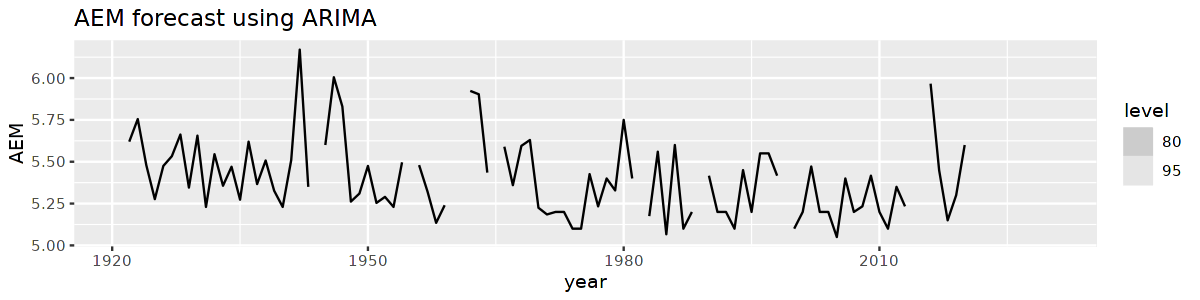

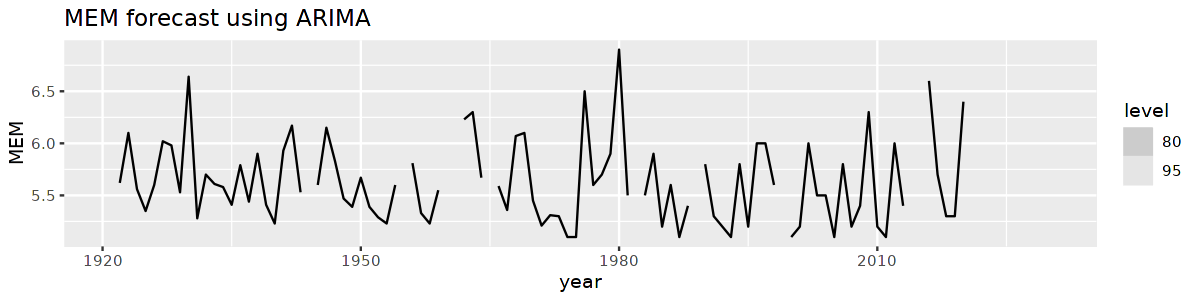

In [18]:
# ARIMA forecast for AEM and MEM with 80% and 95% confidence intervals

options(repr.plot.width=10, repr.plot.height=2.5)

fc_AEM %>%  autoplot(AEM_tsb) + ggtitle('AEM forecast using ARIMA')

fc_MEM %>%  autoplot(MEM_tsb) + ggtitle('MEM forecast using ARIMA')

## 3) Hierarchical cluster analysis 

### 3.1 Spatial clustering
The last study that we performed on our database is a Hierarchical cluster analysis. The aim of this section is to aggregate groups of earthquakes having similar characteristics to discover trends and similarty initally hidden between them. The first type of clustering that we performed is a simple spatial one. We made use of the function hclust to create the dendrogram and then we grouped the top 10 cluster and plotted them on the area of our study to visualize them.

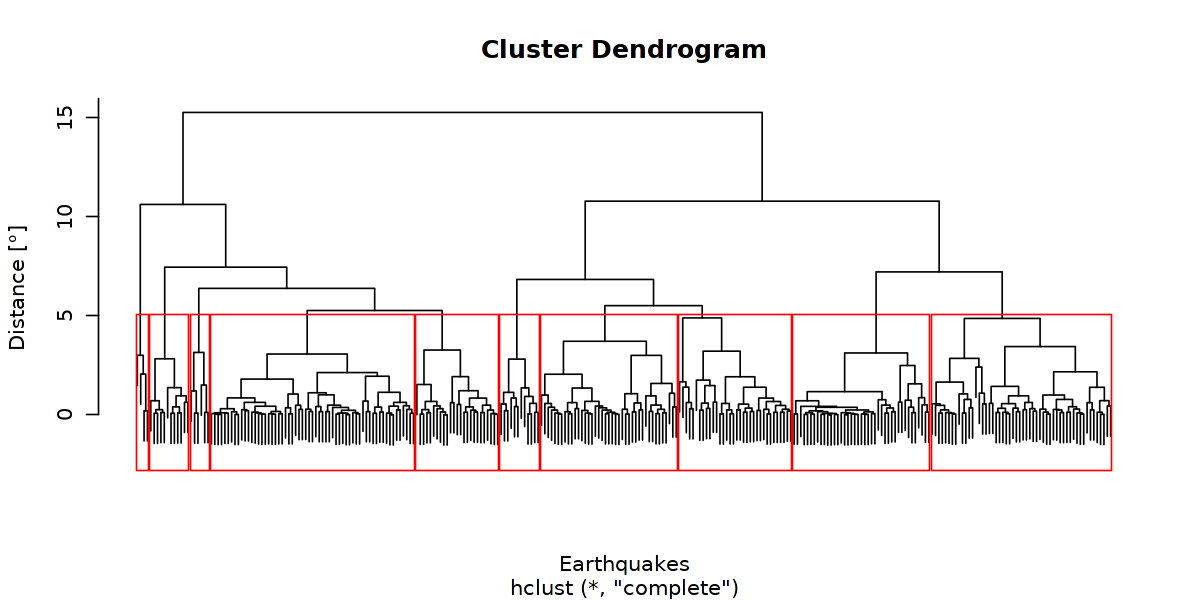

In [19]:
# Hierarchical cluster analysis -> dendrogram creation

subdf_HC<-data.frame(df_ts$longitude, df_ts$latitude)

#rownames(subdf_HC) <- paste0("sample_" , seq(1,290)) # If u want labels

dist_HC<-dist(subdf_HC, method = 'euclidean', diag=TRUE)

x_HC<-hclust(dist_HC, method = "complete")

options(repr.plot.width=10, repr.plot.height=5)

plot(x_HC, 
    main = "Cluster Dendrogram", 
    labels = FALSE, #No labels, put NULL if u want labels and uncomment rownames
    xlab = "Earthquakes", 
    ylab = "Distance [°]",
    axes = TRUE)

groups <- cutree(x_HC, k=10) # cut tree into 10 clusters
rect.hclust(x_HC, k=10, border="red") # draw dendogram with red borders around the 10 clusters 

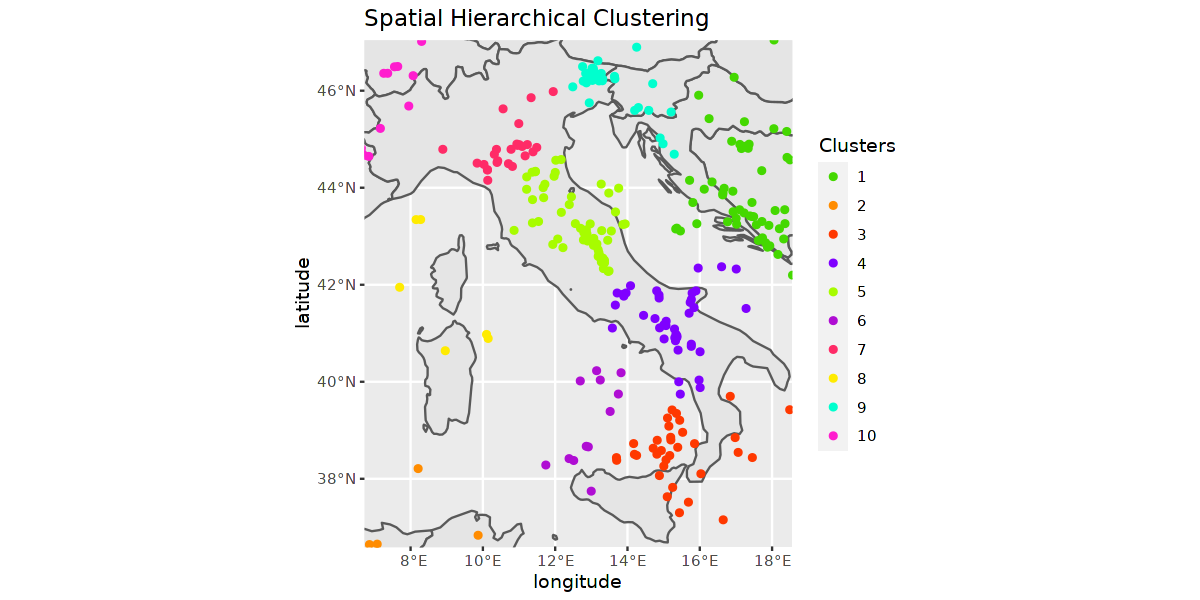

In [20]:
df_clust <- df_ts %>% mutate(spatial_cluster = as.character(groups))
palette <- c('#44d800',"#ff8c00","#ff3800","#7f00ff","#a7fc00","#af0dd3","#ff2b67","#ffeb00","#00ffce","#ff1dce")
palette_names <- c('1','2','3','4','5','6','7','8','9','10')
options(repr.plot.height=5)

ggplot(data = world) +
    geom_sf() +
    geom_point(data = df_clust, aes(x=longitude,y=latitude,color=spatial_cluster), )+
    scale_color_manual(aesthetics = "colour", values=palette,name = 'Clusters', breaks= palette_names)+
    coord_sf(xlim = c(minLong, maxLong), ylim = c(minLat, maxLat), expand = FALSE)+
    ggtitle('Spatial Hierarchical Clustering')

### 3.2 Space-Time clustering

After we performed the simple spacial clustering we asked ourself if we could get more meaningful information from the clustering. The answer is yes, but we have to include additional parameters, like the time when the earthqwuake happened. Doing this is not as simple as it sounds, doing a spacial and time clustering requires to use a different metric from the euclidean one, which one to use? While doing reasearch on this topic we found an article from the professor Marco Baiesi [3], inside this article we found a reference to another article by Cliff Frohlich and Scott D. Davis[4] that also implemented a space-time clustering. We based our analysis on their work and chose to use a distance function in our 4D space-time analysis equal to $\sqrt{d^2+C^2t^2}$ where:

-) d is the distance between two events in kilometers
-) t is the time distance between two events in days
-) C is a constant expressed as Km/day that represents the wheight of the time distance in respect to the space distance. A high value of C means that in our clustering we are valuing more the time distance in respect to the space one. 

Once we obtained our new definition of distance in our space-time framework we implemented the same hclust() function as the spatial clustering and performed a second clustering. By changing the value of C is possible to visualize how the clustering algorythm changes the top 10 clusters.

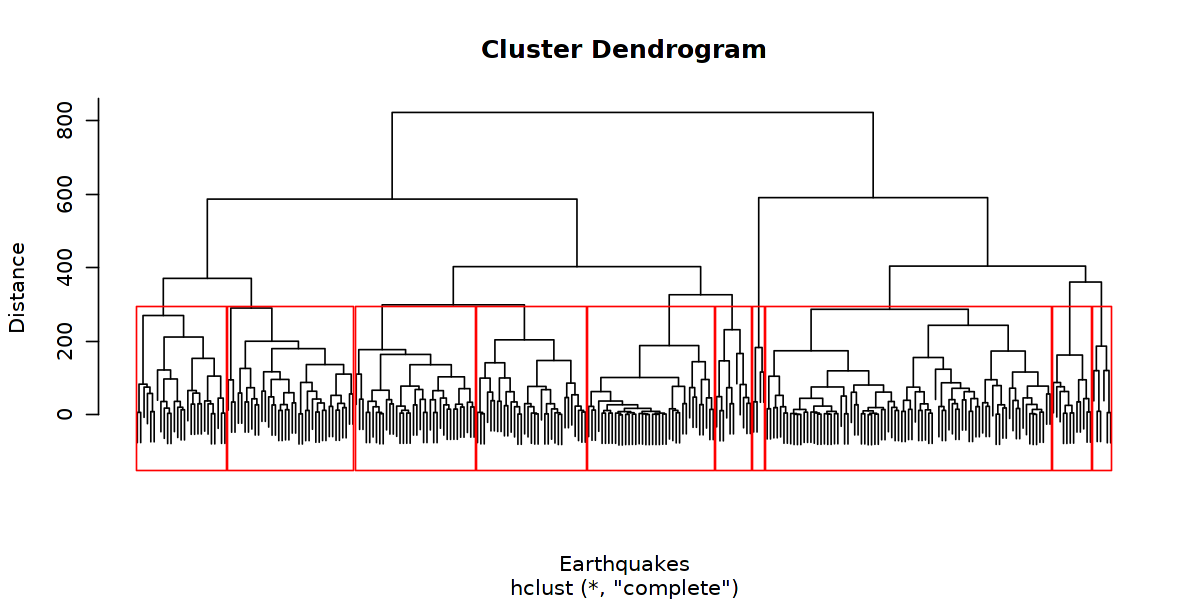

In [21]:
# Space-time clustering

R <- 6371 # Mean earth radius

C <- 0.005 # This parameter is the weight of the time in respect to the space, higher C means 
          # that the time is more important than when having lower C

STdistance <- matrix(nrow = 290, ncol = 290)

for (n1 in 1:290){
    for (n2 in n1:290){
        a <- (1-cos(pi/360*(df_t$latitude[n2]-df_t$latitude[n1])))/2+cos(pi/360*(df_t$latitude[n1]))*cos(pi/360*(df_t$latitude[n2]))*(1-cos(pi/360*(df_t$longitude[n2]-df_t$longitude[n1])))/2
        space_diff <- 2*R*asin(sqrt(a))
        time_diff <- as.double(difftime(df_t$time[n1], df_t$time[n2], unit = "days"))
        STdistance[n2,n1] <- sqrt(C^2*time_diff^2+space_diff^2)
    }
}

STdistance <- as.dist(STdistance)

x_HC<-hclust(STdistance, method = "complete")

options(repr.plot.width=10, repr.plot.height=5)

plot(x_HC, 
    main = "Cluster Dendrogram", 
    labels = FALSE, 
    xlab = "Earthquakes", 
    ylab = "Distance",
    axes = TRUE)

groups <- cutree(x_HC, k=10) # cut tree into 10 clusters
rect.hclust(x_HC, k=10, border="red") # draw dendogram with red borders around the 10 clusters 

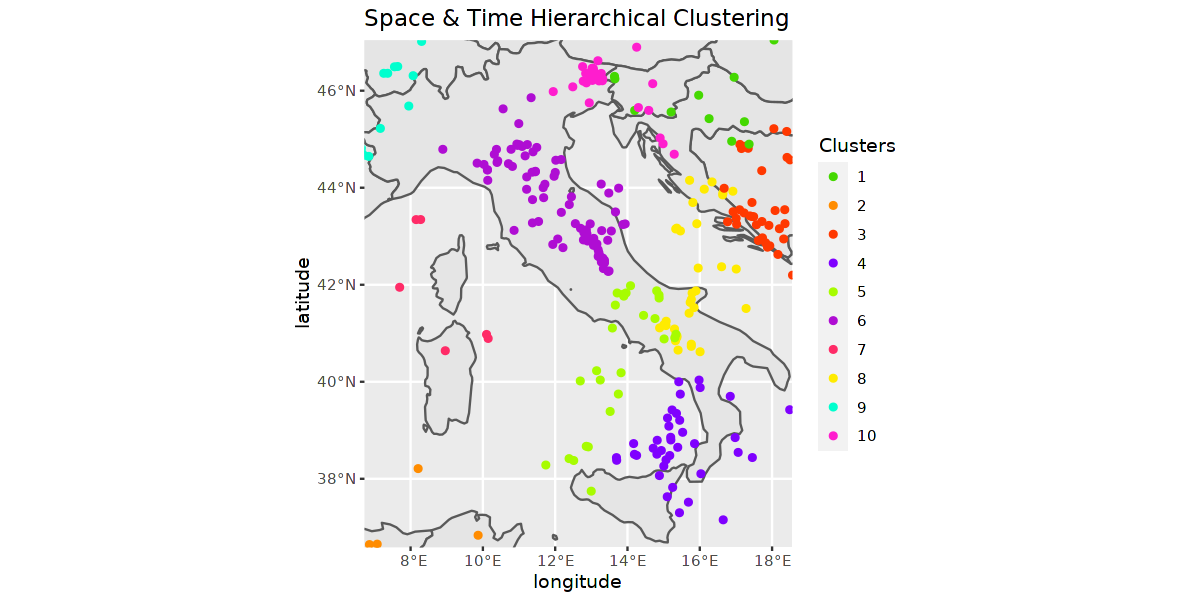

In [22]:
df_clust <- df_ts %>% mutate(space_time_cluster = as.character(groups))
options(repr.plot.height=5)

ggplot(data = world) +
    geom_sf() +
    geom_point(data = df_clust, aes(x=longitude,y=latitude,color=space_time_cluster), )+
    scale_color_manual(aesthetics = "colour", values=palette,name = 'Clusters', breaks= palette_names)+
    coord_sf(xlim = c(minLong, maxLong), ylim = c(minLat, maxLat), expand = FALSE)+
    ggtitle('Space & Time Hierarchical Clustering')


### 3.3 Finding seismic swarms

Now that we found a way to calculate the distance between events in a space-time framework it is possible to do the final stap of our project, find seismic swarms in our data. 
We did that by changing the constant C value to be equal to 1 (same value implemented in article [4]) and by imposing that elements in a cluster should not be distant to each other more than 80 Km/day (33% more than the 60 Km/day of the paper [4] but this value allows us to better visualize the swarms).

We notice that there are multiple swarms in the area corresponding to the Abruzzo, Friuli Venezia Giulia  and Emilia Romagna regions. Having the clusters right in these areas indicates to us that the procedure implemented to find seismic swarms hidden in our data works exactly in the way that we hoped for.

In [23]:
# Finding seismic swarms

R <- 6371 # Mean earth radius

C <- 1 #C=1 is the right parameter to find seismic swarms reported in the article [4]

STdistance <- matrix(nrow = 290, ncol = 290)

for (n1 in 1:290){
    for (n2 in n1:290){
        a <- (1-cos(pi/360*(df_t$latitude[n2]-df_t$latitude[n1])))/2+cos(pi/360*(df_t$latitude[n1]))*cos(pi/360*(df_t$latitude[n2]))*(1-cos(pi/360*(df_t$longitude[n2]-df_t$longitude[n1])))/2
        space_diff <- 2*R*asin(sqrt(a))
        time_diff <- as.double(difftime(df_t$time[n1], df_t$time[n2], unit = "days"))
        STdistance[n2,n1] <- sqrt(C^2*time_diff^2+space_diff^2)
    }
}

STdistance <- as.dist(STdistance)

x_HC<-hclust(STdistance, method = "complete")

options(repr.plot.width=10, repr.plot.height=5)

SwarmLabel <- cutree(x_HC, h=80) #Create clusters of elements distant to each other max 80 Km/Day
Swarm<-as.data.frame(table(SwarmLabel))
SeismicSwarm<-subset(Swarm, Freq>3) #We consider a group of earthquakes to be a swarm in n>3
#SeismicSwarm

In [24]:
SwarmIndex <- df_ts %>% mutate(Id = as.character(SwarmLabel)) %>% count(Id) %>% filter(n > 3) %>% rowid_to_column("cluster")
SeismicSwarm_df <- df_ts %>% mutate(SeismicSwarm = as.character(SwarmLabel)) %>% 
                        filter(SeismicSwarm %in% SwarmIndex$Id) %>% 
                        arrange(as.numeric(SeismicSwarm)) %>%
                        mutate(condition =  SeismicSwarm != lag(SeismicSwarm, default = first(SeismicSwarm)),
                               Cluster= as.character(cumsum(condition) + 1), condition = NULL)

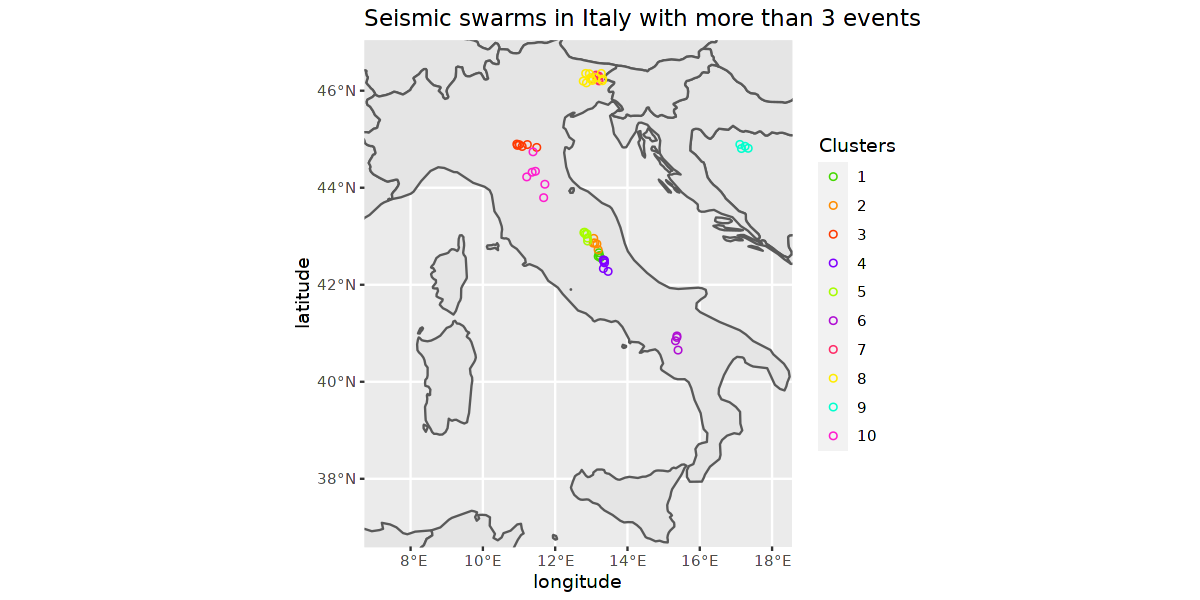

In [25]:
#SwarmIndex <- df_ts %>% mutate(Id = as.character(SwarmLabel)) %>% count(Id) %>% filter(n > 3)
#SeismicSwarm_df <- df_ts %>% mutate(SeismicSwarm = as.character(SwarmLabel)) %>% filter(SeismicSwarm %in% SwarmIndex$Id)

options(repr.plot.height=5)

ggplot(data = world) +
    geom_sf() +
    geom_point(data = SeismicSwarm_df, aes(x=longitude,y=latitude,color=Cluster),shape = 21, alpha=1 )+
    scale_color_manual(aesthetics = "colour", values=palette,name = 'Clusters', breaks= palette_names)+
    coord_sf(xlim = c(minLong, maxLong), ylim = c(minLat, maxLat), expand = FALSE)+
    ggtitle('Seismic swarms in Italy with more than 3 events')

## Bibliography

[1]https://earthquake.usgs.gov/

[2]https://www.researchgate.net/publication/352414349_Prediction_of_the_earthquake_magnitude_by_time_series_methods_along_the_East_Anatolian_Fault_Turkey

[3]https://arxiv.org/pdf/cond-mat/0309485.pdf

[4]https://academic.oup.com/gji/article/100/1/19/614911

[5]http://zonesismiche.mi.ingv.it/


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5ccaee47-4773-4887-a8d2-8dc5d2a2646b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>